In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import seaborn as sns

In [3]:
# Count the number of images on the different folders downloaded
# Open RDD2020 then open test1, test2 and train and on each folder count the number of images on the images folder

num_images_2020 = {}

for folder in ['test1', 'test2', 'train']:
    for region in ['Czech', 'India', 'Japan']:
        path = f'../RDD2020/{folder}/{region}/images/'

        # Add the number of images or initialize it
        if region not in num_images_2020:
            num_images_2020[region] = {}
        if 'test' not in num_images_2020[region]:
            num_images_2020[region]['test'] = 0
        if 'train' not in num_images_2020[region]:
            num_images_2020[region]['train'] = 0

        num_images_2020[region]['test' if 'test' in folder else 'train'] += len(os.listdir(path))

for region in num_images_2020:
    num_images_2020[region]['total'] = num_images_2020[region]['test'] + num_images_2020[region]['train']

num_images_2020

{'Czech': {'test': 709, 'train': 2829, 'total': 3538},
 'India': {'test': 1959, 'train': 7706, 'total': 9665},
 'Japan': {'test': 2627, 'train': 10506, 'total': 13133}}

In [4]:
# Open RDD2022 then open images and count the number of images for each region (this time I don't have anotations for the test images)

num_images_2022 = {}

for region in ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'United_States']:
    path = f'../RDD2022/images/{region}/'

    if region not in num_images_2022:
        num_images_2022[region] = {}

    for folder in os.listdir(path):
        if folder == '.DS_Store': continue # Ignore this MacOS file
        if folder not in num_images_2022:
            num_images_2022[region][folder] = 0

        num_images_2022[region][folder] += len(os.listdir(path + folder + '/images/'))

for region in num_images_2022:
    num_images_2022[region]['total'] = sum(num_images_2022[region].values())

num_images_2022


{'China_Drone': {'train': 2401, 'total': 2401},
 'China_MotorBike': {'test': 500, 'train': 1977, 'total': 2477},
 'Czech': {'test': 709, 'train': 2829, 'total': 3538},
 'India': {'test': 1959, 'train': 7706, 'total': 9665},
 'Japan': {'test': 2627, 'train': 10506, 'total': 13133},
 'United_States': {'test': 1200, 'train': 4805, 'total': 6005}}

### It looks like the images for Czech, India and Japan are the same in both datasets which means we can use the test anotations from the old dataset in the new one. However, I don't have the test annotations for the other countries so I will have to split those myself.

In [5]:
# Total number of images anotated and not anotated in RDD2022.

total_images_2022 = 0
total_anotated_2022 = 0
total_not_anotated_2022 = 0

for region in num_images_2022:
    total_images_2022 += num_images_2022[region]['total']
    if region in ['Czech', 'India', 'Japan']:
        total_anotated_2022 += num_images_2022[region]['total']
    else:
        if 'test' in num_images_2022[region]:
            total_not_anotated_2022 += num_images_2022[region]['test']
        total_anotated_2022 += num_images_2022[region]['train']

total_images_2022, total_anotated_2022, total_not_anotated_2022

(37219, 35519, 1700)

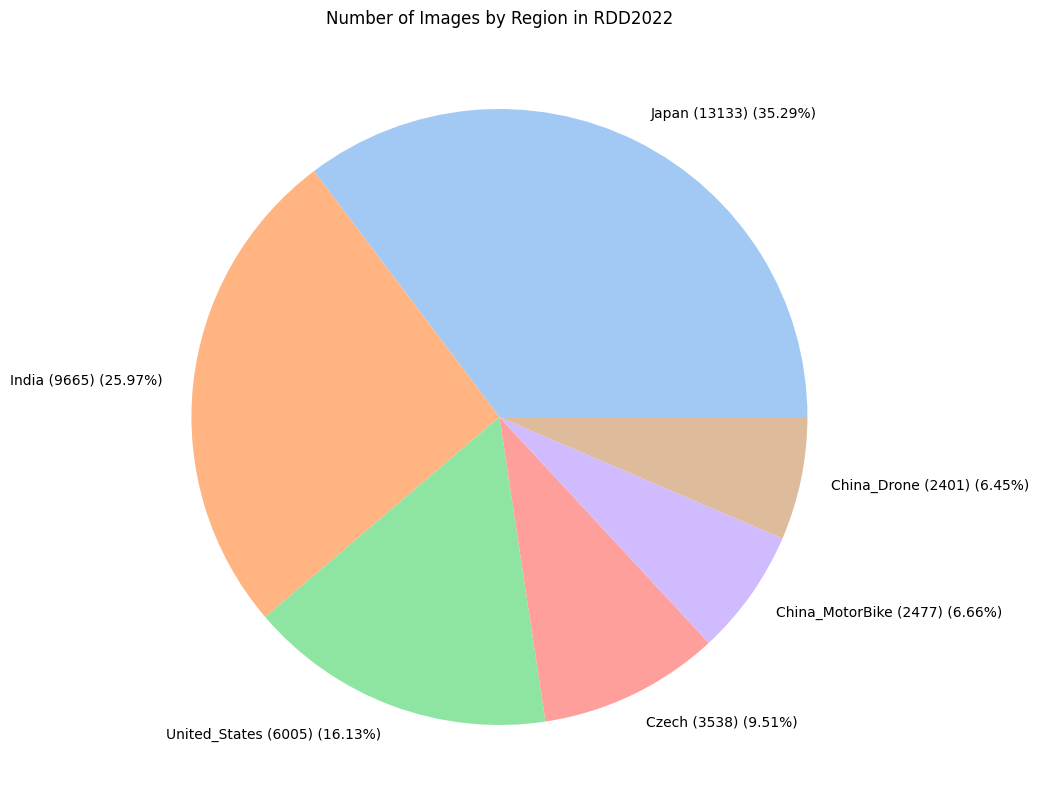

In [6]:
# With seaborn create pie charts for the number of images by country
num_images_2022_df = pd.DataFrame(num_images_2022).T

plt.figure(figsize=(10, 10))
# Show Name of Region, Total Images for that Region, Percentage of Total Images inside it's pie segment (Dont show percentage in the middle and move the labels inside the pie)
# Order the regions by total number of images
num_images_2022_df = num_images_2022_df.sort_values('total', ascending=False)
plt.pie(num_images_2022_df['total'], labels=[f'{region} ({int(num_images_2022_df["total"][region])}) ({round(num_images_2022_df["total"][region] / total_images_2022 * 100, 2)}%)' for region in num_images_2022_df.index], colors=sns.color_palette('pastel'))
plt.title('Number of Images by Region in RDD2022')
plt.show()

In [7]:
# Read the type of anotation for each image in RDD2022 and count total number of each type of anotation
anotation_types_2022 = {}

for region in ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'United_States']:
    # Open the anotations folder for each region
    path = f'../RDD2022/images/{region}/train/annotations/xmls/'

    # If the region is not in the dictionary add it
    if region not in anotation_types_2022:
        anotation_types_2022[region] = {}
    
    # For each file in the folder
    for file in os.listdir(path):
        # If it is not a xml file ignore it
        if file[-4:] != '.xml': continue

        # Open the xml file
        tree = ET.parse(path + file)
        root = tree.getroot()

        # The anotations are inside the object tag and the type of anotation is inside the name tag
        for obj in root.findall('object'):
            name = obj.find('name').text

            # Detect errors in the anotations
            if name == 'D0w0': print(file)

            # If the type of anotation is not in the dictionary add it
            if name not in anotation_types_2022[region]:
                anotation_types_2022[region][name] = 0

            # Add one to the type of anotation
            anotation_types_2022[region][name] += 1

# From anotation_types_2022 lets get all the unique types of anotations
anotation_types = set()

for region in anotation_types_2022:
    for anotation_type in anotation_types_2022[region]:
        anotation_types.add(anotation_type)

anotation_types_2022, anotation_types, len(anotation_types)

({'China_Drone': {'D10': 1263,
   'D40': 86,
   'D00': 1426,
   'Repair': 769,
   'D20': 293,
   'Block crack': 3},
  'China_MotorBike': {'D10': 1096,
   'D20': 641,
   'D00': 2678,
   'Repair': 277,
   'D40': 235},
  'Czech': {'D00': 988, 'D10': 399, 'D20': 161, 'D40': 197},
  'India': {'D20': 2021,
   'D00': 1556,
   'D40': 3187,
   'D44': 1062,
   'D43': 57,
   'D10': 68,
   'D11': 45,
   'D01': 179,
   'D50': 28},
  'Japan': {'D50': 3553,
   'D00': 4049,
   'D44': 3995,
   'D20': 6199,
   'D10': 3979,
   'D40': 2243,
   'D43': 736},
  'United_States': {'D00': 6750, 'D10': 3295, 'D20': 834, 'D40': 135}},
 {'Block crack',
  'D00',
  'D01',
  'D10',
  'D11',
  'D20',
  'D40',
  'D43',
  'D44',
  'D50',
  'Repair'},
 11)

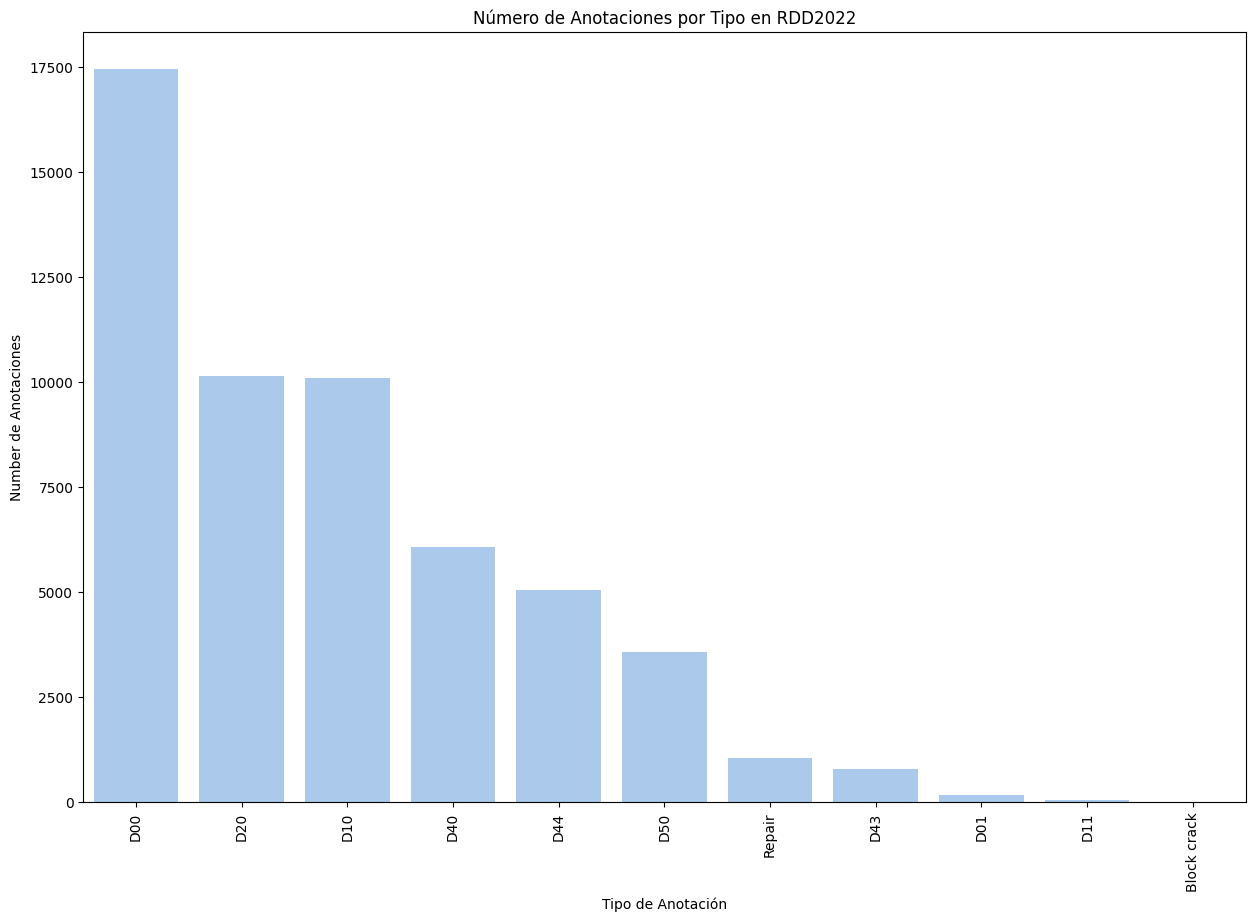

In [13]:
# For every type of anotation calculate the total number of occurences in RDD2022
anotation_types_2022_total = {}

for anotation_type in anotation_types:
    anotation_types_2022_total[anotation_type] = 0

    for region in anotation_types_2022:
        if anotation_type in anotation_types_2022[region]:
            anotation_types_2022_total[anotation_type] += anotation_types_2022[region][anotation_type]

# Using seaborn plot bar graph with the number of occurences of each type of anotation (vertical lines from largest to smallest in x axis)
anotation_types_2022_total_df = pd.DataFrame(anotation_types_2022_total, index=['total']).T.sort_values('total', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x=anotation_types_2022_total_df.index, y=anotation_types_2022_total_df['total'], color=sns.color_palette('pastel')[0])
plt.xticks(rotation=90)
plt.title('Número de Anotaciones por Tipo en RDD2022')
plt.xlabel('Tipo de Anotación')
plt.ylabel('Number de Anotaciones')
plt.show()

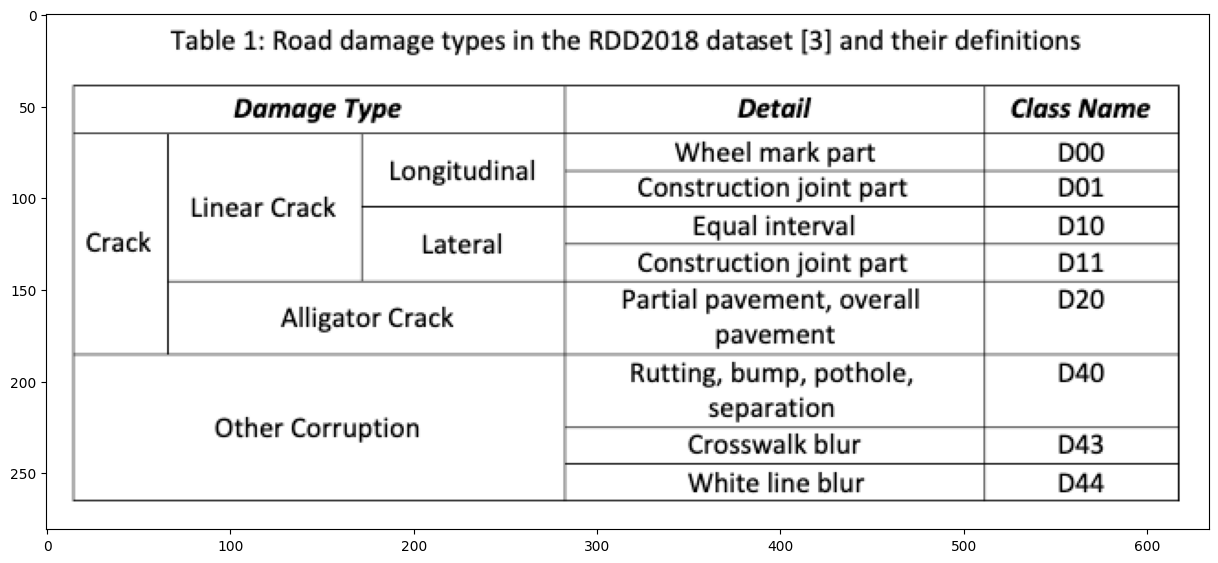

In [9]:
# Show annotations_meaning image
image = cv2.imread('../data/annotations_meaning.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(image)

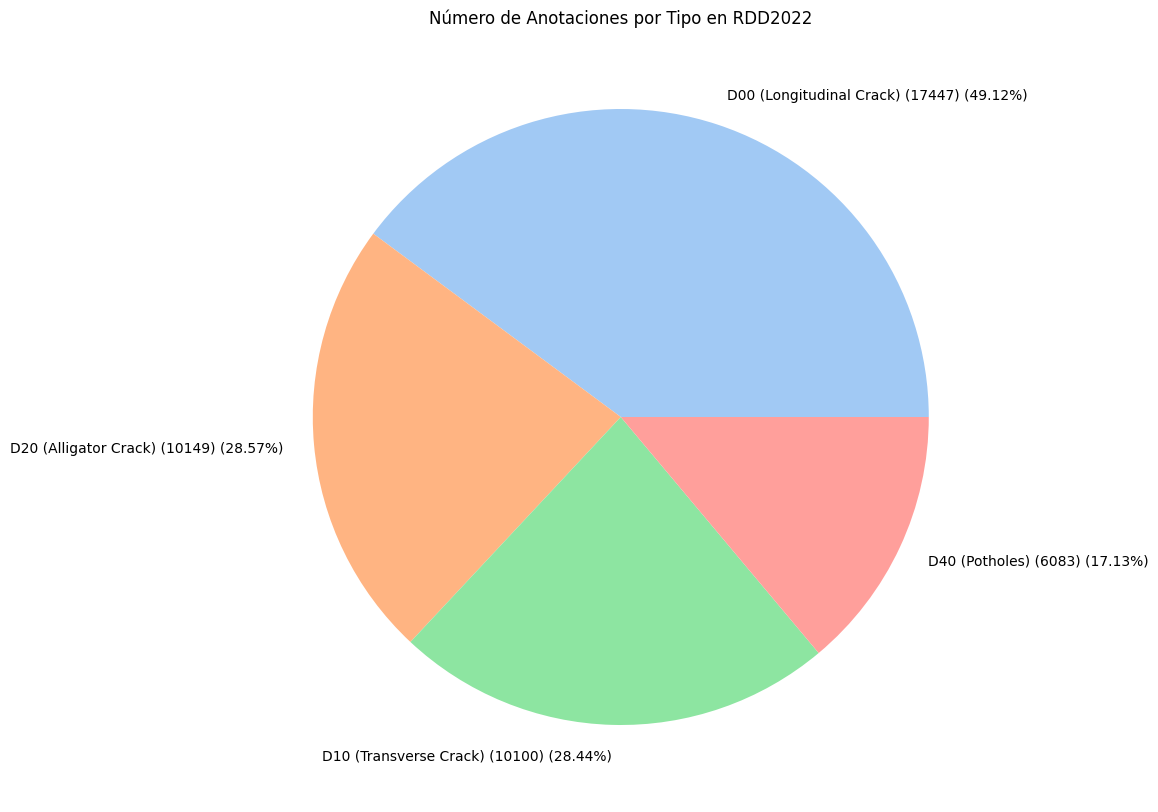

In [10]:
# The competition only considers the following types of anotations D00 Longitudinal Crack, D10 (Transverse Crack), D20 (Alligator Crack), and D40 (Potholes)
# So lets create a new dictionary with only these types of anotations
anotation_types_2022_total = {}

anotation_map = {
    'D00': 'Longitudinal Crack',
    'D10': 'Transverse Crack',
    'D20': 'Alligator Crack',
    'D40': 'Potholes'
}

for anotation_type in ['D00', 'D10', 'D20', 'D40']:
    anotation_types_2022_total[anotation_type] = 0

    for region in anotation_types_2022:
        if anotation_type in anotation_types_2022[region]:
            anotation_types_2022_total[anotation_type] += anotation_types_2022[region][anotation_type]

# Using seaborn plot bar graph with the number of occurences of each type of anotation (vertical lines from largest to smallest in x axis)
anotation_types_2022_total_df = pd.DataFrame(anotation_types_2022_total, index=['total']).T.sort_values('total', ascending=False)

plt.figure(figsize=(15, 10))
# Pie Plot
plt.pie(anotation_types_2022_total_df['total'], labels=[f'{anotation_type + " (" + anotation_map[anotation_type] + ")"} ({int(anotation_types_2022_total_df["total"][anotation_type])}) ({round(anotation_types_2022_total_df["total"][anotation_type] / total_anotated_2022 * 100, 2)}%)' for anotation_type in anotation_types_2022_total_df.index], colors=sns.color_palette('pastel'))
plt.title('Número de Anotaciones por Tipo en RDD2022')
plt.show()


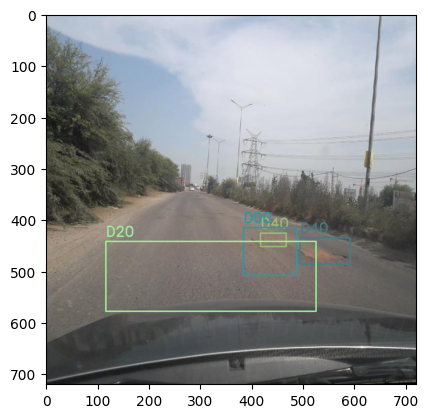

In [11]:
# Lets open an image and show the anotations for it
# United_States_000001, Japan_000015
image_name = 'India_000147'
region = image_name.split('_')[0]

image_path = '../RDD2022/images/' + region + '/train/images/' + image_name + '.jpg'
anotation_xml_path = '../RDD2022/images/' + region + '/train/annotations/xmls/' + image_name + '.xml'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tree = ET.parse(anotation_xml_path)
root = tree.getroot()

for obj in root.findall('object'):
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    name = obj.find('name').text
    # Random color for each object
    color = tuple([int(x) for x in np.random.randint(0, 255, size=3)])
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

plt.imshow(image)

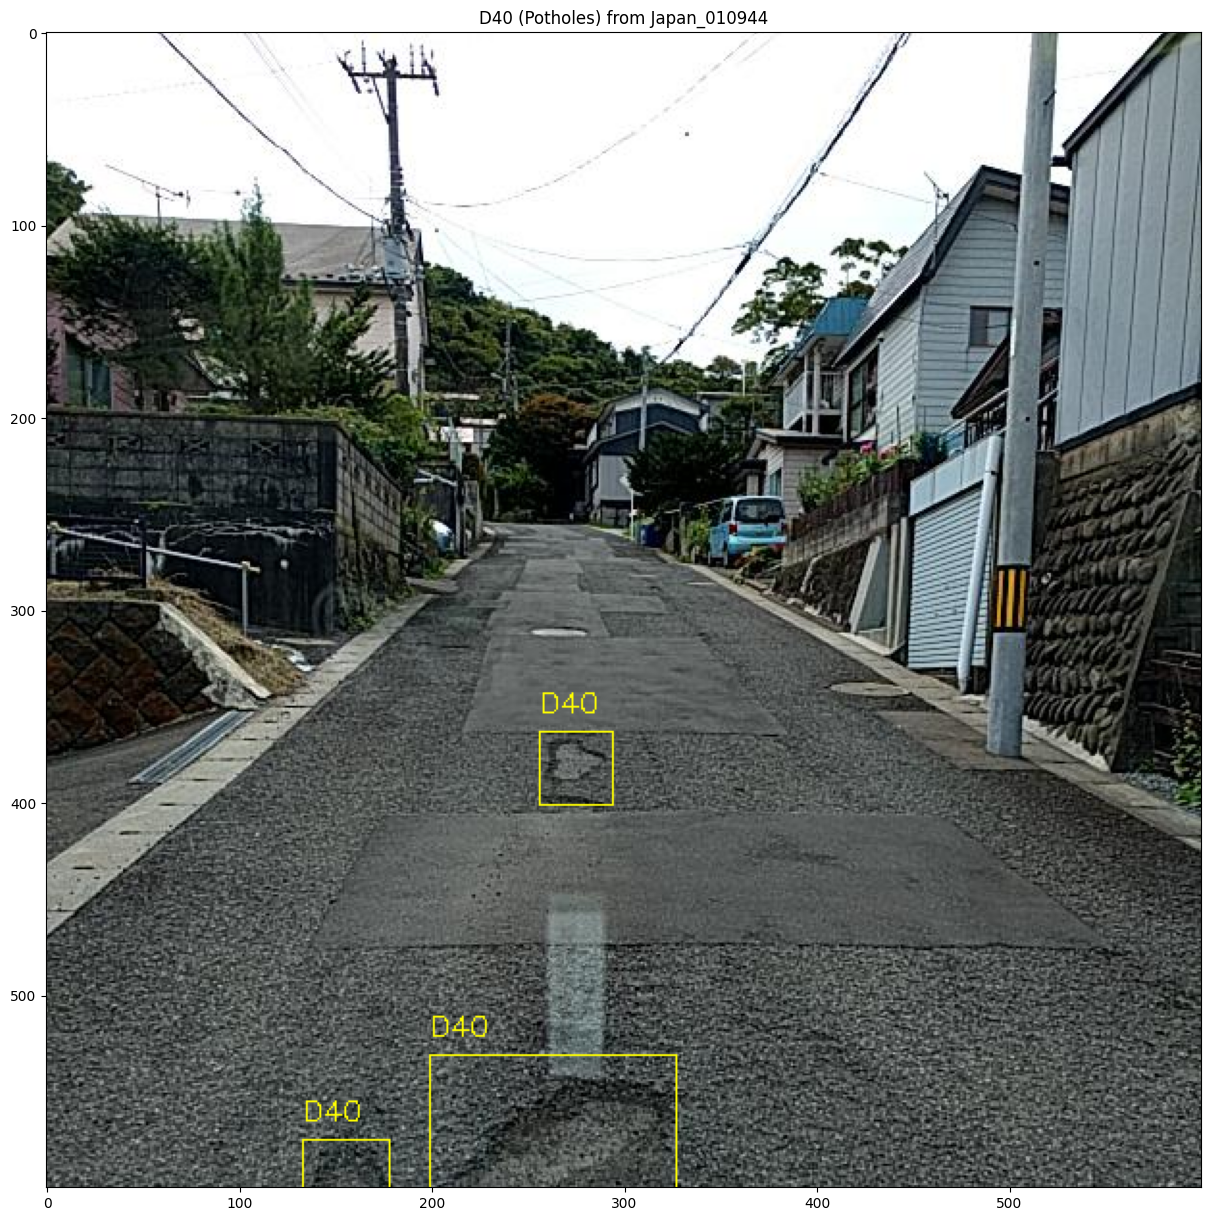

In [12]:
# For the anotations D00 Longitudinal Crack, D10 (Transverse Crack), D20 (Alligator Crack), and D40 (Potholes) show an example of each that can be included in the paper
label_names = ['D00', 'D10', 'D20', 'D40']
get = 'D40'

color_map = {
    'D00': (255, 0, 0),
    'D10': (0, 255, 0),
    'D20': (0, 0, 255),
    'D40': (255, 255, 0)
}

for label_name in label_names:

    if label_name != get: continue

    while True:
        # Random region
        region = np.random.choice(['Czech', 'India', 'Japan', 'China_Drone', 'China_MotorBike', 'United_States'])
        image_name = np.random.choice(os.listdir(f'../RDD2022/images/{region}/train/images/')).split('.')[0]
        anotation_xml_path = f'../RDD2022/images/{region}/train/annotations/xmls/{image_name}.xml'

        tree = ET.parse(anotation_xml_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            name = obj.find('name').text

            if name == label_name:
                break
        else:
            continue

        break

    image_path = '../RDD2022/images/' + region + '/train/images/' + image_name + '.jpg'
    anotation_xml_path = '../RDD2022/images/' + region + '/train/annotations/xmls/' + image_name + '.xml'

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    tree = ET.parse(anotation_xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        # Only show the current anotation
        if obj.find('name').text != label_name: continue

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        name = obj.find('name').text
        # Random color for each object
        color = tuple([int(x) for x in np.random.randint(0, 255, size=3)])
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color_map[name], 1)
        cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_map[name], 1)

    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.title(f'{label_name} ({anotation_map[label_name]}) from {image_name}')
    plt.show()